In [3]:
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import os
import sys
sys.path.append('../')
import utils as ul
import copy
import pickle
import gzip
from scipy.signal import medfilt
import h5py
from scipy.stats import norm
import time
import pymultinest
import json
import copy
font = {'family':'serif', 'size':15}
plt.rc('font', **font)
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
plt.rc('axes', labelsize='small')

dir0 = os.getcwd()
t = Table.read('../../data/candidate_list_nqso.csv', format='ascii.csv')
plate_hits = t['plate'].data
mjd_hits = t['mjd'].data
fiber_hits = t['fiber'].data
tag_hits = t['tag'].data
note_hits = t['note'].data

#only select the single/double peak tag
idd = np.where(np.logical_or(tag_hits=='single',tag_hits=='double'))
plate_hits = plate_hits[idd]
mjd_hits = mjd_hits[idd] 
fiber_hits = fiber_hits[idd]
tag_hits = tag_hits[idd]
note_hits = note_hits[idd]

in_dir = '/data/inspur_disk03/userdir/caoxy/eboss_lya/data/'
lya_hits = pickle.load(gzip.open(in_dir+'lya_hits_cut.pzip'))

dir1 = os.getcwd()
os.chdir('/data/inspur_disk03/userdir/caoxy/eboss_lya/data/2')
dir2 = os.getcwd()

plate_list_pickle = lya_hits['plate_hits']
fiber_list_pickle = lya_hits['fiber_hits']
mjd_list_pickle = lya_hits['mjd_hits']
spec_id_list_pickle = lya_hits['spec_id']
peak_id_list_pickle = lya_hits['peak_id']
peak_wave_list_pickle = lya_hits['peak_wave']
peak_sn_list_pickle = lya_hits['peak_sn']

peak_wave_hits = []
peak_sn_hits = []
spec_id_hits = []
peak_id_hits = []
for ii,item in enumerate(plate_hits[:]):
    condition = np.logical_and((plate_list_pickle==plate_hits[ii]), (mjd_list_pickle==mjd_hits[ii]))
    condition = np.logical_and(condition, (fiber_list_pickle==fiber_hits[ii]))
    id_pickle = np.where(condition)[0][0]
    #print(id_pickle)
    #print('---------')
    #print(plate_list_pickle[id_pickle],plate_hits[ii])
    #print(mjd_list_pickle[id_pickle],mjd_hits[ii])
    #print(fiber_list_pickle[id_pickle],fiber_hits[ii])
    peak_wave_hits.append(peak_wave_list_pickle[id_pickle])
    peak_sn_hits.append(peak_sn_list_pickle[id_pickle])
    spec_id_hits.append(spec_id_list_pickle[id_pickle])
    peak_id_hits.append(peak_id_list_pickle[id_pickle])
    
peak_wave_hits = np.array(peak_wave_hits)
peak_sn_hits = np.array(peak_sn_hits)
spec_id_hits = np.array(spec_id_hits)
peak_id_hits = np.array(peak_id_hits)


multi_line_hits  = [False]*plate_hits.size
main_wave_hits = []
main_skewness_hits = []
main_flux_hits = []
main_width_hits = []
sub_wave_hits = []
sub_skewness_hits = []
sub_flux_hits = []
sub_width_hits = []
tot_flux_hits = []

mm = 0 
nn = plate_hits.size
plate_hits = plate_hits[mm:nn]
mjd_hits = mjd_hits[mm:nn]
fiber_hits = fiber_hits[mm:nn] 
tag_hits = tag_hits[mm:nn] 
note_hits = note_hits[mm:nn] 
peak_wave_hits = peak_wave_hits[mm:nn]
peak_sn_hits = peak_sn_hits[mm:nn]
spec_id_hits = spec_id_hits[mm:nn]
peak_id_hits = peak_id_hits[mm:nn] #peak index in sdss spec
multi_line_hits = multi_line_hits[mm:nn] #whether it have multi-line

for ii,item in enumerate(plate_hits[0:nn]):
    this_plate = plate_hits[ii]
    this_mjd = mjd_hits[ii]
    this_fiber = fiber_hits[ii]
    this_spec_id = spec_id_hits[ii]
    this_peak_id = peak_id_hits[ii]
    this_peak_wave = peak_wave_hits[ii]
    this_peak_sn = peak_sn_hits[ii]
    h5_file = '{}_{}.h5'.format(this_plate,this_mjd)
    with h5py.File(h5_file, 'r') as f:
        arr0 = f['flux']
        flux = arr0[:]
        
        arr1 = f['loglam']
        loglam = arr1[:]
        
        arr2 = f['zans']
        zans = arr2[:]
        
        arr3 = f['newsynflux']
        synflux = arr3[:]
        
        arr4 = f['res_ivar']
        res_ivar = arr4[:]
    

    this_wave = 10**loglam
    this_flux = flux[this_spec_id,:]
    this_synflux = synflux[this_spec_id,:]
    this_resflux = this_flux - this_synflux
    this_res_ivar = res_ivar[this_spec_id,:]
    this_sn = np.sqrt(this_resflux**2 * this_res_ivar)   

    hw_sub = 50 #empirically choice
    wave_sub = this_wave[this_peak_id-hw_sub:this_peak_id+hw_sub+1]
    resflux_sub =  this_resflux[this_peak_id-hw_sub:this_peak_id+hw_sub+1]
    res_ivar_sub = this_res_ivar[this_peak_id-hw_sub:this_peak_id+hw_sub+1]
    sn_sub = this_sn[this_peak_id-hw_sub:this_peak_id+hw_sub+1]
    
    #------------------------------read fitting block---------------
    #fitting x-coordinates
    npix = wave_sub.size
    wave_fit = np.arange(0,npix)
    #fitting data/uncertainty
    dlam = wave_sub * 1.0e-4 * np.log(10.0)
    #obs = np.copy(resflux_sub * dlam)
    #weight = np.copy(res_ivar_sub / dlam**2)
    #ul.npix = np.copy(npix)
    #ul.obs = np.copy(obs)
    #ul.weight = np.copy(weight)
    #ul.wave_fit = np.copy(wave_fit)
    png_name = '{}-{}-{}'.format(this_plate,this_mjd,this_fiber)
    multinest_base_dir = '/data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/'
    
    #remove repetive single/double
    peak_type = tag_hits[ii]
    #print(peak_type)
    output = subprocess.Popen('ls -d {}{}/{}*'.format(multinest_base_dir, peak_type, png_name),stdout=subprocess.PIPE,shell=True)
    lines = output.stdout.read().splitlines()
    k_hits = len(lines)
    if k_hits > 1:
        #id_repeated.append(ii)
        multi_line_hits[ii] = True
        print(r'Warning, multiple({}) line detection in one spectra!!!, {}'.format(k_hits,png_name))
        cmd = 'cp {0}/full_spectra/{1}*  {0}/multi_hits_check/{2}_{1}.png'.format(dir0,png_name.replace('-','_'),peak_type)
        #print(cmd)
        os.system(cmd)
        #continue  #ignore those repeated sample now
    if k_hits==0: continue #some systems fitting by multinest,may be a quasar, thus has been exclude from the *no_sqso.csv catalog
    if ii%100 == 1:
        print('{} iteration'.format(ii))
    #id_cutted.append((ii))

    
    multinest_output = multinest_base_dir+'single/'+png_name+'_{}/'.format(k_hits)
    parameters = ['A', 'x', 'omega', 's']
    n_params = len(parameters)       
    res = pymultinest.Analyzer(outputfiles_basename=multinest_output, n_params = n_params)
    xx_single = res.get_best_fit()     
    
    multinest_output = multinest_base_dir+'double/'+png_name+'_{}/'.format(k_hits)
    parameters = ['flux_ratio', 'offset', 'omega1', 's1', 'A2', 'x2', 'omega2', 's2']
    n_params = len(parameters)
    res = pymultinest.Analyzer(outputfiles_basename=multinest_output, n_params = n_params)
    xx_double = res.get_best_fit()
    
    obs = np.copy(resflux_sub)    
    if tag_hits[ii] == 'single':
        cube = xx_single['parameters']
        chi2_single = xx_single['log_likelihood']*(-2.0)
        mock = ul.skew_gauss(npix , cube[0], cube[1], cube[2], cube[3],hw_sub=2)
        mock /= dlam
        #sume tmp varaible
        delta = cube[3]/np.sqrt(cube[3]*cube[3]+1)
        lambda0 = cube[1] + cube[2]*delta*np.sqrt(2.0/np.pi)
        sigma0 = cube[2]*np.sqrt(1-2*delta**2/np.pi) 
        lambda1 = 0.0
        sigma1 = 0.0
        
        #main_wave = np.interp(cube[1], np.arange(npix), wave_sub)
        main_wave = np.interp(lambda0, np.arange(npix), wave_sub)
        sub_wave = main_wave
        main_skewness = cube[3]
        sub_skewness = 0.0
        main_width = sigma0  #still in pixel units, one pixel --> 70km/s
        sub_width = 0.0
        main_flux = mock.sum()
        sub_flux = 0.0
        tot_flux = main_flux
        
        main_wave_hits.append(main_wave)
        main_width_hits.append(main_width)
        main_skewness_hits.append(main_skewness)
        main_flux_hits.append(main_flux)
        sub_wave_hits.append(sub_wave)
        sub_width_hits.append(sub_width)
        sub_skewness_hits.append(sub_skewness)
        sub_flux_hits.append(sub_flux)
        tot_flux_hits.append(tot_flux)
    elif tag_hits[ii] == 'double':
        cube = xx_double['parameters']
        chi2_double = xx_double['log_likelihood']*(-2.0)
        mock = ul.double_peak(npix , cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6], cube[7],hw_sub=2)
        mock /= dlam
        #sume tmp varaible
        delta0 = cube[7]/np.sqrt(cube[7]*cube[7]+1)
        delta1 = cube[3]/np.sqrt(cube[3]*cube[3]+1)     
        lambda0 = cube[5] + cube[6]*delta0*np.sqrt(2.0/np.pi)
        sigma0 = cube[6]*np.sqrt(1-2*delta0**2/np.pi)       
        lambda1 = (cube[1]+cube[5]) + cube[2]*delta1*np.sqrt(2.0/np.pi)
        sigma1 = cube[2]*np.sqrt(1-2*delta1**2/np.pi) 
        
        main_wave = np.interp(lambda0, np.arange(npix), wave_sub)
        sub_wave = np.interp(lambda1, np.arange(npix), wave_sub)
        main_skewness = cube[7]
        sub_skewness = cube[3]
        main_width = sigma0
        sub_width = sigma1
        #parameters = ['flux_ratio', 'offset', 'omega1', 's1', 'A2', 'x2', 'omega2', 's2']
        mock_main = ul.skew_gauss(npix , cube[4], cube[5], cube[6], cube[7],hw_sub=2)/dlam
        mock_sub = ul.skew_gauss(npix , cube[4]*cube[0], cube[1]+cube[5], cube[2], cube[3],hw_sub=2)/dlam
        main_flux = mock_main.sum()
        sub_flux = mock_sub.sum()
        tot_flux =  mock.sum() #cube[4]*(1+cube[0])
        #print('------', main_flux+sub_flux,tot_flux)
        
        main_wave_hits.append(main_wave)
        main_width_hits.append(main_width)
        main_skewness_hits.append(main_skewness)
        main_flux_hits.append(main_flux)
        sub_wave_hits.append(sub_wave)
        sub_width_hits.append(sub_width)
        sub_skewness_hits.append(sub_skewness)
        sub_flux_hits.append(sub_flux)
        tot_flux_hits.append(tot_flux)
        
    fig_f = 2
    fig,ax = plt.subplots(figsize=(3*fig_f,2*fig_f))
    zoom_hw = 40  #control the plot size
    ctr = int((wave_sub.size-1)/2)
    wave_plot = wave_sub[ctr-zoom_hw:ctr+zoom_hw+1]
    resflux_plot = resflux_sub[ctr-zoom_hw:ctr+zoom_hw+1]
    mock_plot = mock[ctr-zoom_hw:ctr+zoom_hw+1]
    ax.bar(wave_plot,resflux_plot,alpha=0.5)
    ax.plot(wave_plot,mock_plot,linewidth=1.0,linestyle='dashed',color='black')
    #ax.axvline(x=main_wave,color='magenta')
    #ax.axvline(x=sub_wave,color='magenta')
    textstr1 = r'Spec-ID: {}-{}-{}'.format(this_plate,this_mjd,this_fiber)
    ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=10,
            verticalalignment='top')
    textstr2 = r'Line flux: {:.2f}'.format(tot_flux)
    ax.text(0.65, 0.95, textstr2, transform=ax.transAxes, fontsize=10,
            verticalalignment='top')
    ax.minorticks_on()
    up_lim = resflux_sub.max()*1.2
    if resflux_sub.min() < 0:
        low_lim = resflux_sub.min()*1.2
    else:
        low_lim = -0.1
    ax.set_ylim(low_lim,up_lim)
    ax.set_ylabel('$\\rm f_{\\lambda} \ [10^{-17} erg cm^{-2} s^{-1} Ang^{-1}]$') #,fontsize=20
    ax.set_xlabel(r'Observed wavelength [Ang]')
    #plt.show()
    fig.savefig('{}/plot_zoomed_spectra/{}_{}_{}.pdf'.format(dir0,this_plate,this_mjd,this_fiber),bbox_inches='tight')
    plt.close(fig)
    #res = pymultinest.Analyzer(outputfiles_basename=multinest_output, n_params = n_params)
    #fig.savefig('{}/full_spectra/{}_{}_{}.png'.format(dir0,this_plate,this_mjd,this_fiber),bbox_inches='tight')
    #plt.close(fig)
os.chdir(dir0)
print('----------')
#from astropy.io import ascii
#id_repeated = np.array(id_repeated)
#id_cutted = np.array(id_cutted)
#ascii.write([id_repeated,],'{}/multi_hits_check/repeated_index.dat'.format(dir0), names=['id_muti_line'],overwrite=True)

  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/single/10243-58159-381_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/double/10243-58159-381_1/.txt
1 iteration
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/single/10272-58172-937_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/double/10272-58172-937_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/single/10274-58170-211_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/double/10274-58170-211_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/single/10287-58101-813_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/data/multinest_out/double/10287-58101-813_1/.txt
  analysing data from /data/inspur_disk03/userdir/caoxy/eboss_lya/da

In [2]:
#write all data
#data_list = [plate_hits, mjd_hits, fiber_hits, tag_hits, note_hits, 
#             peak_wave_hits, peak_sn_hits, spec_id_hits, peak_id_hits,
#             multi_line_hits, main_wave_hits, main_skewness_hits, main_flux_hits, main_width_hits, sub_wave_hits, sub_skewness_hits, sub_flux_hits, sub_width_hits,
#             tot_flux_hits
#            ]
#cols_name = ('plate', 'mjd', 'fiber', 'tag', 'note',
#             'sn_peak_wave','peak_sn','spec_id', 'peak_id',
#             'if_multi_line','main_wave','main_skewness','main_flux','main_width','sub_wave','sub_skewness','sub_flux','sub_width',
#             'tot_flux'
#            )
#t = Table(data_list, names=cols_name, meta={'name': 'results table'})
#t.write('../../data/catalog_1_by_zoomed_spectra.csv',format='ascii.csv',overwrite=True)

In [3]:
#write no multi-line table info
from astropy.table import Table

id_s = np.where(np.array(multi_line_hits)==False)
num_tot = id_s[0].size
data_list = [plate_hits, mjd_hits, fiber_hits, tag_hits, note_hits, 
             peak_wave_hits, peak_sn_hits, spec_id_hits, peak_id_hits,
             multi_line_hits, main_wave_hits, main_skewness_hits, main_flux_hits, main_width_hits, sub_wave_hits, sub_skewness_hits, sub_flux_hits, sub_width_hits,
             tot_flux_hits
            ]
for ii in range(len(data_list)):
    if not isinstance(data_list[ii],np.ndarray):
        data_list[ii] = np.array(data_list[ii])
    if data_list[ii].size > num_tot:
            data_list[ii] = (data_list[ii])[id_s]
        

cols_name = ('plate', 'mjd', 'fiber', 'tag', 'note',
             'sn_peak_wave','peak_sn','spec_id', 'peak_id',
             'if_multi_line','main_wave','main_skewness','main_flux','main_width','sub_wave','sub_skewness','sub_flux','sub_width',
             'tot_flux'
            )
t = Table(data_list, names=cols_name, meta={'name': 'results table'})
t.write('../../data/catalog_1_by_zoomed_spectra.csv',format='ascii.csv',overwrite=True)

In [4]:
data_list[0].size

690

In [18]:
a=[1,2,3]
for i in a:
    i=i+1
print(a)

[1, 2, 3]


In [17]:
isinstance(main_flux_hits,np.ndarray)

False

In [11]:
plate_hits[np.where(np.array(multi_line_hits)==True)]

array([3682, 6200, 7152, 7152, 9412, 3682, 4484, 5969, 5969, 6200, 6254,
       6254])

In [4]:
for item in data_list:
    print(len(item))

702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702


In [1]:
import numpy as np
a=np.array([1,2,3])


In [13]:
a=[1,2,3]

In [14]:
a[0:3]

[1, 2, 3]

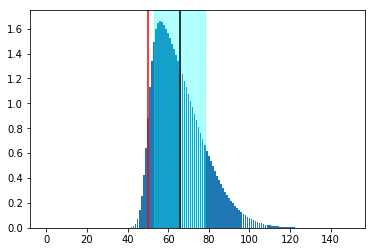

In [34]:
npix=150
cube = [1.0, 50.0, 20, 5.0]
single_mock = ul.skew_gauss(npix , cube[0], cube[1], cube[2], cube[3],hw_sub=2)

delta = cube[3]/np.sqrt(cube[3]*cube[3]+1)
lambda0 = cube[1] + cube[2]*delta*np.sqrt(2.0/np.pi)
sigma0 = cube[2]*np.sqrt(1-2*delta**2/np.pi) 
plt.figure()
plt.bar(np.arange(npix),single_mock)
plt.axvline(x=lambda0,color='black')
plt.axvspan(lambda0-sigma0,lambda0+sigma0,alpha=0.3,color='cyan')
plt.axvline(x=cube[1],color='red')
plt.show()

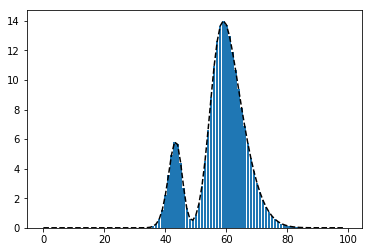

(211.03693478764768, 211.03693478764765)


In [12]:
cube = [0.5, -10, 3.0, -1.0, 10.0, 55.0, 8.0, 1.8]
npix=100
mock_double = ul.double_peak(npix , cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6], cube[7],hw_sub=2)
mock_main = ul.skew_gauss(npix , cube[4], cube[5], cube[6], cube[7],hw_sub=2)
mock_sub = ul.skew_gauss(npix , cube[4]*cube[0], cube[1]+cube[5], cube[2], cube[3],hw_sub=2)

plt.figure()
plt.bar(np.arange(npix),mock_double)
plt.plot(np.arange(npix),mock_main+mock_sub,'k--')
plt.show()
print(mock_main.sum()+mock_sub.sum(),mock_double.sum())

In [9]:
single_mock.sum()

8.883975368388636

In [4]:
'{}/zoomed_spectra/{}_{}_{}.png'.format(dir0,this_plate,this_mjd,this_fiber)

'/data/inspur_disk03/userdir/caoxy/eboss_lya/py/paper_figure_plot/zoomed_spectra/10272_58172_937.png'

In [8]:
main_wave_hits

[3760.5254611284104, 3755.9989578108516]

In [4]:
dlam

array([0.85470391, 0.85490073, 0.8550976 , 0.85529452, 0.85549148,
       0.85568849, 0.85588554, 0.85608264, 0.85627978, 0.85647697,
       0.8566742 , 0.85687148, 0.85706881, 0.85726618, 0.85746359,
       0.85766105, 0.85785856, 0.85805611, 0.85825371, 0.85845135,
       0.85864904, 0.85884677, 0.85904455, 0.85924238, 0.85944025,
       0.85963817, 0.85983613, 0.86003413, 0.86023219, 0.86043029,
       0.86062843, 0.86082662, 0.86102486, 0.86122314, 0.86142146,
       0.86161984, 0.86181825, 0.86201672, 0.86221523, 0.86241378,
       0.86261238, 0.86281103, 0.86300972, 0.86320846, 0.86340725,
       0.86360608, 0.86380495, 0.86400387, 0.86420284, 0.86440185,
       0.86460091, 0.86480002, 0.86499917, 0.86519836, 0.8653976 ,
       0.86559689, 0.86579623, 0.86599561, 0.86619503, 0.8663945 ,
       0.86659402, 0.86679359, 0.86699319, 0.86719285, 0.86739255,
       0.8675923 , 0.86779209, 0.86799193, 0.86819182, 0.86839175,
       0.86859173, 0.86879175, 0.86899182, 0.86919194, 0.86939

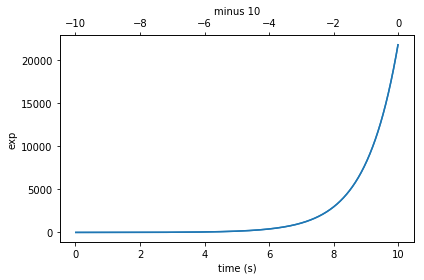

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
t2 = np.arange(0.01, 10.0, 0.01) -10
data1 = np.exp(t)

fig, ax1 = plt.subplots()


ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp')
ax1.plot(t, data1)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax2.set_xlabel('minus 10')  # we already handled the x-label with ax1
ax2.plot(t2, data1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()